In [33]:
from numpy.random import choice
from WikipediaWordCounter import WikipediaWordCounter 
from collections import Counter
from string import digits, punctuation
import matplotlib.pyplot as plt
import json

# Most Common Words in `.nyc` Domain Names

Having a memorable url is important. One of the most memorable top level domains is `.nyc`, administered by New York City. [New York Open Data](https://opendata.cityofnewyork.us/) has a list of all the registered `.nyc` domains. What are the most common words in a `.nyc` url? 

## Data Preparation 

First, we should take a look at the data. 

In [16]:
with open("nyc_Domain_Registrations.csv") as infile: 
    raw_data = infile.read().split('\n') 
for line in raw_data[:4]:
    print(line) 

Domain Name ,Domain Registration Date ,Nexus Category
000.nyc,12/27/2016 05:01:47 AM,ORG
001.nyc,12/23/2015 05:41:17 PM,INDIV
007names.nyc,10/08/2014 03:48:29 PM,INDIV


Looks like it's formatted well enough, let's grab all the domain names. While we're at it, we'll also remove any numbers or punctuation from the url. After all, it's words we're interested in. 

In [17]:
remove_digits_translation_table = str.maketrans('', '', digits + punctuation)
def remove_digits(s): 
    return s.translate(remove_digits_translation_table)
print(remove_digits("123abc456def"))

abcdef


Let's look at a few random ones. 

In [18]:
domain_names = [remove_digits(line.split(',')[0][:-4]) for line in raw_data][1:]
for domain_name in choice(domain_names, 7, replace = False):
    print(domain_name)

vernissage
theluxurycollection
lfn
weedclub
hospitalityconsulting
hashish
umkd


Immediately we notice that many urls are comprised of more than one word concatenated together. Ideally we'd like to count each word in the url. For example, we'd like to count `morninginsider` as `[morning, insider]`. How can we split up a continuous string of letters into words? We can do it using dynamic programming! For each string, we'll consider all possible splits of the string and take the one that is most likely. 

## Finding Word Frequency

How do we measure which string split is most likely? For that, we can find the relative frequency of words by examining some corpus. The corpus is an important decision. There are many choices: a year's worth of Google searches, all the words in the Library of Congress, all of your email from last year. Since we're taking a look at `.nyc` domains, we want to make sure that `manhattanbeach` is split into `[manhattan, beach]` and not `[man, hat, tan, beach]`. So let's use NYC related Wikipedia articles as our corpus. 

I wrote a small class to do just that. WikipediaWordCounter will count the frequency of words on Wikipedia pages. It starts with the seed term, in this case `New York City`, and then proceeds to recursively visit random links from its current page, counting the words on each page. It does so until a predefined depth and makes sure to never count the same page twice. 

In [6]:
wwc = WikipediaWordCounter("New York City", depth = 3, num_links = 5)
wwc.run()
wwc.save() 

scraping New York City
scraping North Atlantic Division
scraping Division (military)
scraping U.S. Army Corps of Engineers
scraping Fort Hamilton
scraping Nuclear bomb
scraping Brooklyn, New York
scraping Copenhagen
scraping Special Operations Executive
scraping Parks and open spaces in Copenhagen
scraping London
scraping Kdam Eurovision
scraping Roskilde Fjord
scraping Wayne R. Dynes
scraping Stonewall Uprising
scraping WorldCat
scraping Système universitaire de documentation
scraping Stavelot Bible
scraping Cato Institute
scraping Bronx Zoo
scraping Corporal Thompson Park
scraping Green Central Knoll
scraping Snow White and the Seven Dwarfs (1937 film)
scraping Green junglefowl
scraping Nubian ibex
scraping Education in New York City
scraping Loyola School (New York)
scraping Bibliothèque nationale de France
scraping Pelham Bay Park
scraping George Sand
scraping List of New York City gardens


In [8]:
nyc_wiki_word_counts = wwc.get_wc() 
len_longest_word = max(len(word) for word in nyc_wiki_word_counts)

Let's take a quick look at the distribution of word frequency over these Wikipedia Pages. 

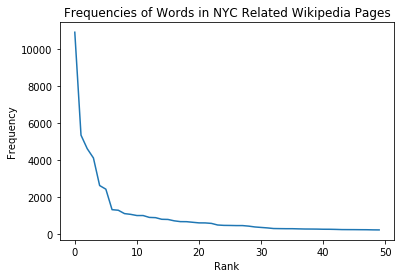

In [32]:
plt.plot([(val) for _, val in nyc_wiki_word_counts.most_common(50)])
plt.title("Frequencies of Words in NYC Related Wikipedia Pages")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.show()

The frequencies look to approximately follow [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law). That is, the rank and frequency are inversely related. 

## Inferring Spaces

To determine which split is most likely, we'll take the split with the smallest total cost. We'll need a mapping from each word to its cost. More common words should cost less than less common words. We can use the inverse relative frequency. 

In [14]:
word_cost = dict((word, sum(nyc_wiki_word_counts.values())/count) for word, count in nyc_wiki_word_counts.items())
def infer_spaces(s): 
    
    def best_match(i): 
        candidates = enumerate(reversed(cost[max(0, i-len_longest_word):i]))
        return min((c + word_cost.get(s[i-k-1:i], 9e999), k+1) for k,c in candidates)
    
    cost = [0]
    for i in range(1, len(s) + 1): 
        c, k = best_match(i) 
        cost.append(c) 
        
    out = [] 
    i = len(s) 
    while i > 0: 
        c, k = best_match(i) 
        assert c == cost[i]
        out.append(s[i-k:i]) 
        i -= k
    
    return [i for i in reversed(out)]

The above function was shamelessly stolen from [StackOverflow](https://stackoverflow.com/a/11642687). 

How well does it do? 

In [13]:
print(infer_spaces("thequickbrownfoxjumpedoverthelazydog"))
print(infer_spaces("manhattanbeach"))

['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']
['manhattan', 'beach']


Pretty well, I'd say. And it's fast and lightweight - linear in time and memory. 

## Most common words 

Now all that's left to do is split each domain name into its likely constituent words.

In [19]:
domain_wc = Counter() 
for domain_name in domain_names: 
    if domain_name: 
        domain_wc.update(infer_spaces(domain_name))

[(word, freq) for word, freq in domain_wc.most_common(10)]

[('a', 21237),
 ('r', 19411),
 ('e', 17664),
 ('s', 17078),
 ('i', 14701),
 ('c', 13110),
 ('t', 10955),
 ('m', 10678),
 ('l', 10589),
 ('n', 7547)]

The most frequent "words" in a url are individual letters. What about word's longer than two characters? 

In [25]:
for word, freq in domain_wc.most_common(100):
    if len(word) > 2: 
        print(word + '\t' + str(freq))

the	2121
and	1115
art	915
nyc	818
new	801
york	591
one	572
are	554
brooklyn	524
city	508
men	489
for	486
age	484
all	474
real	473
car	471
her	410
law	405
park	394
group	381
per	376
our	365
home	363
design	342
air	307
tech	302
house	285
manhattan	282
you	274
hotel	259
street	257
life	255


This wouldn't be a proper NLP post if `the` and `and` weren't at the top of a word frequency list. Surprisingly `brooklyn` comes out ahead over `manhattan`. Unsurprisingly, `.nyc` is very artsy, with `art` coming in third. `law`, `tech`, and housing terms show what else is important to `.nyc` domain holders.

In [36]:
data = {"meta":
           {"title":".nyc domain names word frequency"}, 
        "data":domain_wc}
with open('nyc_domains_wc.json','w') as outfile: 
    json.dump(data, outfile, indent=2)